In [22]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
torch.manual_seed(42)
import numpy as np
from collections import defaultdict
from autograd_lib import autograd_lib


from torch.utils.data import DataLoader, TensorDataset

In [23]:
import os

result_folder = "finalResult_with_hessian4_final1"

if not os.path.exists(result_folder):
    os.mkdir(result_folder)

In [24]:
Y_func = lambda x : (torch.sin(5*np.pi*x)) /(5*np.pi*x) 
num_of_rows = 300
X= torch.unsqueeze(torch.linspace(-1,1,num_of_rows),dim=1)
Y = Y_func(X)
dataset = TensorDataset(X,Y)
data_loader = DataLoader(dataset,1,shuffle=True)

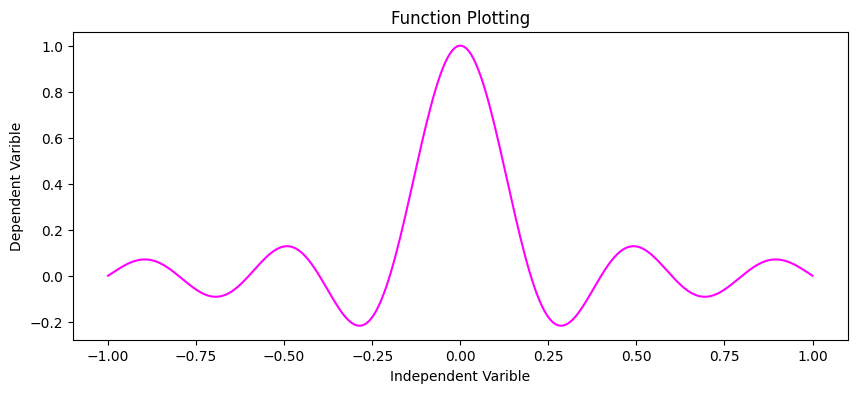

In [25]:
plt.figure(figsize=(10,4))
plt.plot(X, Y, color = "magenta")
plt.title('Function Plotting')
plt.xlabel('Independent Varible')
plt.ylabel('Dependent Varible')
plt.savefig(result_folder+'/func1_plot1.2.png')

In [26]:
class MathRegressor(nn.Module):
    def __init__(self, num_hidden=128):
        super().__init__()
        self.regressor = nn.Sequential(
            nn.Linear(1, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, 1)
        )

    def forward(self, x):
        x = self.regressor(x)
        return x
    
    
    
    def training_step(self, batch,loss_fn):
        inputs, targets = batch 
        out = self(inputs)                
        loss = loss_fn(out, targets)    
        return loss
    
    def validation_step(self, batch,loss_fn):
        inputs, targets = batch 
        out = self(inputs)                 
        loss = loss_fn(out, targets)   
        return {'val_loss': loss.detach()}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        return {'val_loss': epoch_loss.item()}
    
    def train_step(self, batch,loss_fn):
        inputs, targets = batch 
        out = self(inputs)                
        loss = loss_fn(out, targets)    
        return {'train_loss': loss.detach()}
    
    def train_epoch_end(self, outputs):
        batch_losses = [x['train_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  
        return {'train_loss': epoch_loss.item()}
    
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}".format(epoch, result['val_loss']))
    
    

In [37]:
def compute_gradient_norm(model, criterion, train, target):
    model.train()
    model.zero_grad()
    output = model(train)
    loss = criterion(output, target)
    loss.backward()

    grads = []
    for p in model.regressor.children():
        if isinstance(p, nn.Linear):
            param_norm = p.weight.grad.norm(2).item()
            grads.append(param_norm)

    grad_mean = np.mean(grads) 

    return grad_mean

def save_activations(layer, A, _):
    activations[layer] = A

def compute_hess(layer, _, B):
    A = activations[layer]
    BA = torch.einsum('nl,ni->nli', B, A) 
    hess[layer] += torch.einsum('nli,nkj->likj', BA, BA)
    
def compute_minimum_ratio(model, criterion, train, target):
    model.zero_grad()
    
    with autograd_lib.module_hook(save_activations):
        output = model(train)
        loss = criterion(output, target)

    with autograd_lib.module_hook(compute_hess):
        autograd_lib.backward_hessian(output, loss='LeastSquares')

    layer_hess = list(hess.values())
    minimum_ratio = []

    for h in layer_hess:
        size = h.shape[0] * h.shape[1]
        h = h.reshape(size, size)
        
        # Replacing torch.symeig with torch.linalg.eigvalsh
        h_eig = torch.linalg.eigvalsh(h, UPLO='U')  # 'U' for upper triangular matrix
        num_greater = torch.sum(h_eig > 0).item()
        minimum_ratio.append(num_greater / len(h_eig))

    ratio_mean = np.mean(minimum_ratio) 

    return ratio_mean



In [38]:
def get_norm_minimal_ratio(model,criterion):

    gradient_norm = compute_gradient_norm(model, criterion, X, Y)
    minimum_ratio = compute_minimum_ratio(model, criterion, X, Y)

    print('gradient norm: {}, minimum ratio: {}'.format(gradient_norm, minimum_ratio))
    result = {}
    result["grad_norm"] = gradient_norm
    result["ratio"] = minimum_ratio
    
    return result

In [39]:
def evaluate(model, loss_fn, val_loader):
    outputs = [model.validation_step(batch, loss_fn) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def evaluate2(model, loss_fn, train_loader):
    outputs = [model.train_step(batch, loss_fn) for batch in train_loader]
    return model.train_epoch_end(outputs)

def get_grad_norm(model):
    grad_all = 0.0
    grad = 0
    
    for p in model.parameters():
        if p.grad is not None:
            grad = (p.grad.cpu().data.numpy() ** 2).sum()
        grad_all += grad
        
    grad_norm = grad_all ** 0.5
    return grad_norm

def fit(epochs, lr, model, data_loader, criterion, opt_func):
    history = []
    comparing_epoch_loss = 1000.0
    grad_norm_per_epoch = {}

    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        prediction = model(X)
        loss = criterion(prediction, Y)
        loss.backward()
        grad_norm_per_epoch[epoch] = get_norm_minimal_ratio(model, criterion)
        optimizer.step()
        optimizer.zero_grad()
        result = evaluate(model, criterion, data_loader)
        model.epoch_end(epoch, result)
        history.append(result)
        
        if epoch == 900:
            comparing_epoch_loss = result["val_loss"]
  
    return history, grad_norm_per_epoch, model


In [40]:
num_of_rows = 300
lr = 0.0004
gamma_lr_scheduler = 0.1 
weight_decay = 1e-4
criterion = nn.MSELoss()
optimizer = torch.optim.Adam
num_epochs =2500
criterion_name = "MSE_LOSS_"
optimizer_name = "ADAM_opt"
filename = criterion_name+ optimizer_name+".png"
grad_norm_name = "_grad_norm_name1_2.png"
result_folder_name = "result3/"

In [41]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam
num_epochs =2000
criterion_name = "MSE_LOSS_"
optimizer_name = "ADAM_opt"
input_size=1
output_size=1
model= MathRegressor()

In [42]:
autograd_lib.register(model_1)
activations = defaultdict(int)
hess = defaultdict(float)
           

In [43]:
result_1 = evaluate(model,criterion,data_loader)
result_1

{'val_loss': 0.4016718566417694}

In [44]:
filename = criterion_name+ optimizer_name+".png"

In [45]:
train,target = X,Y

In [46]:
history_1,grad_norm_1,model_1  = fit(num_epochs, lr, model_1, data_loader, criterion,optimizer)

gradient norm: 2.383659452199936, minimum ratio: 0.703125
Epoch [0], val_loss: 0.3954
gradient norm: 2.450784344226122, minimum ratio: 0.6953125
Epoch [1], val_loss: 0.4111
gradient norm: 2.5180913619697094, minimum ratio: 0.72265625
Epoch [2], val_loss: 0.4272
gradient norm: 2.5854485370218754, minimum ratio: 0.71484375
Epoch [3], val_loss: 0.4438
gradient norm: 2.652941904962063, minimum ratio: 0.7421875
Epoch [4], val_loss: 0.4607
gradient norm: 2.720516160130501, minimum ratio: 0.69921875
Epoch [5], val_loss: 0.4782
gradient norm: 2.7881786674261093, minimum ratio: 0.734375
Epoch [6], val_loss: 0.4960
gradient norm: 2.8559238128364086, minimum ratio: 0.71875
Epoch [7], val_loss: 0.5143
gradient norm: 2.9237753264606, minimum ratio: 0.73828125
Epoch [8], val_loss: 0.5330
gradient norm: 2.991733245551586, minimum ratio: 0.73046875
Epoch [9], val_loss: 0.5522
gradient norm: 3.059774350374937, minimum ratio: 0.75390625
Epoch [10], val_loss: 0.5718
gradient norm: 3.127897422760725, mini

In [47]:
grad_norm_1

{0: {'grad_norm': 2.383659452199936, 'ratio': 0.703125},
 1: {'grad_norm': 2.450784344226122, 'ratio': 0.6953125},
 2: {'grad_norm': 2.5180913619697094, 'ratio': 0.72265625},
 3: {'grad_norm': 2.5854485370218754, 'ratio': 0.71484375},
 4: {'grad_norm': 2.652941904962063, 'ratio': 0.7421875},
 5: {'grad_norm': 2.720516160130501, 'ratio': 0.69921875},
 6: {'grad_norm': 2.7881786674261093, 'ratio': 0.734375},
 7: {'grad_norm': 2.8559238128364086, 'ratio': 0.71875},
 8: {'grad_norm': 2.9237753264606, 'ratio': 0.73828125},
 9: {'grad_norm': 2.991733245551586, 'ratio': 0.73046875},
 10: {'grad_norm': 3.059774350374937, 'ratio': 0.75390625},
 11: {'grad_norm': 3.127897422760725, 'ratio': 0.74609375},
 12: {'grad_norm': 3.19608923047781, 'ratio': 0.71875},
 13: {'grad_norm': 3.2643523551523685, 'ratio': 0.7265625},
 14: {'grad_norm': 3.3327057994902134, 'ratio': 0.73046875},
 15: {'grad_norm': 3.4011525362730026, 'ratio': 0.71875},
 16: {'grad_norm': 3.469749730080366, 'ratio': 0.72265625},
 1

In [48]:
val_losses_1 = [r['val_loss'] for r in history_1]

In [49]:
len(val_losses_1)

2000

In [50]:
minimal_ratio_eps = [i['ratio'] for i in grad_norm_1.values() ]

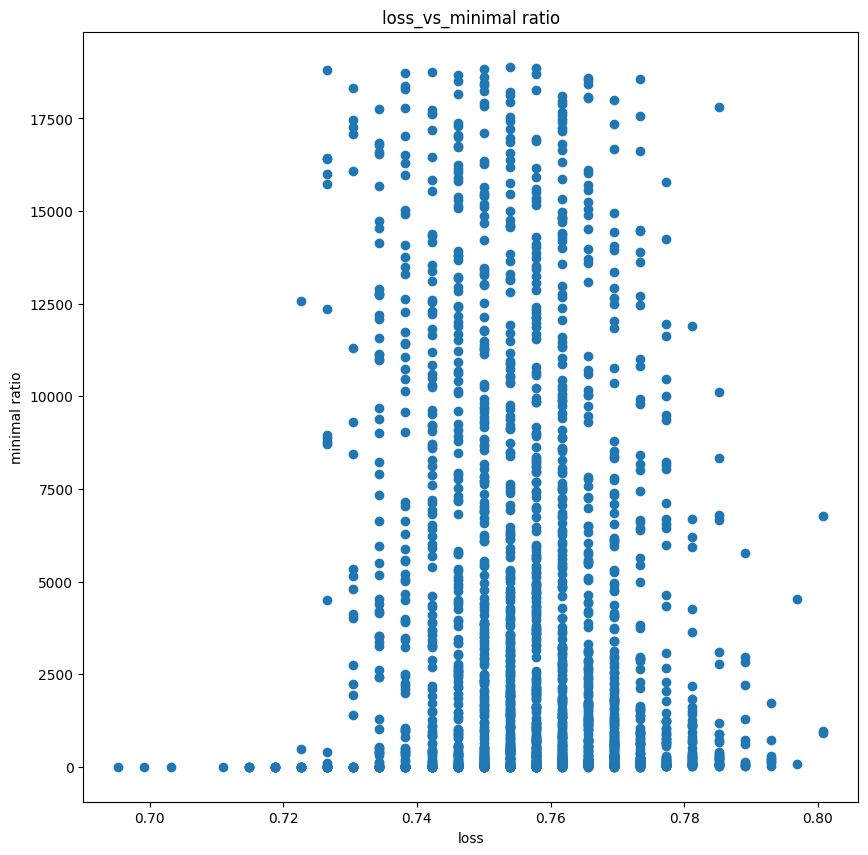

In [51]:
plt.figure(figsize=(10,10))
plt.scatter(minimal_ratio_eps,val_losses_1)
plt.xlabel('loss')
plt.ylabel('minimal ratio')
plt.title('loss_vs_minimal ratio');
plt.plot()
plt.savefig("loss_vs_minimal ratio.png")